# Regularization: Dropout, and Batch Normalization

For educational purposes and for the reason of exploring neural network concepts with the least amount of, we will move away from using more complex optimization algorithms, and stick with the good ol' vanilla SGD. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mnist
from activation import relu, sigmoid, sigmoid_prime, softmax
from helper import one_hot_encoder
from initializer import initialize_weight
%matplotlib inline

from utils import dataloader
from losses import cross_entropy_loss

import warnings
warnings.filterwarnings("ignore")

# Load Dataset
train_x, train_y = mnist.load_dataset(download=True, train=True)
test_x, test_y = mnist.load_dataset(download=True, train=False)

Found and verified data/t10k-images-idx3-ubyte.gz
Found and verified data/t10k-labels-idx1-ubyte.gz
Found and verified data/train-images-idx3-ubyte.gz
Found and verified data/train-labels-idx1-ubyte.gz
Found and verified data/t10k-images-idx3-ubyte.gz
Found and verified data/t10k-labels-idx1-ubyte.gz
Found and verified data/train-images-idx3-ubyte.gz
Found and verified data/train-labels-idx1-ubyte.gz


# Dropout: Neural Networks as ensamble of simpler neural networks

The idea of dropout is to train simpler sub-networks of the whole network, while also sharing parameters with the other sub-networks. You can also think of dropout as convolution with very weak spatial prior. Implementing dropout is as easy as: 

### Forward
1. Generate a dropout mask. Dropout mask is basically a __Bernoulli Distribution__ (parameters with binary values) with shape same as activation output's shape, parametrized by the keep probability 
    
    `mask = np.random.Binomial(1, keep_prob, size=activation_output.shape)`

2. Apply/Multiply the dropout mask 

    `output *= mask`
    
### Backprop
1. Reuse the mask from forward prop, and apply to the gradient with respect to outputs

    `d_output *= mask`

In [2]:
def train(train_x, train_y, learning_rate=0.1, num_epochs=50, batch_size=1, drop_prob=0):
    # Flatten input (num_samples, 28, 28) -> (num_samples, 784) 
    x = train_x.reshape(train_x.shape[0], -1)
    num_samples = x.shape[0]
    
    # Turn labels into their one-hot representations
    y = one_hot_encoder(train_y)

    # Make a data loader
    trainloader = dataloader(x, y, batch_size=batch_size, shuffle=True)
    
    # Initialize weights
    w1, b1 = initialize_weight((784, 256), bias=True)
    w2, b2 = initialize_weight((256, 10), bias=True)

    loss_history = []
    for epoch in range(1, num_epochs+1):
        print("Epoch {}/{}\n===============".format(epoch, num_epochs))

        batch_loss = 0
        acc = 0
        for inputs, labels in trainloader:
            # Number of samples per batch
            m = inputs.shape[0]
            
            # Forward Prop
            h1 = np.dot(inputs, w1) + b1
            a1 = sigmoid(h1)
            
            # Dropout Forward
            if (drop_prob != 0):
                # Bernoulli Distribution
                keep_prob = 1 - drop_prob
                mask1 = np.random.binomial(1, keep_prob, size=a1.shape) 
                
                # Multiply mask
                a1 *= mask1 
            
            h2 = np.dot(a1, w2) + b2
            a2 = softmax(h2)
            out = a2

            # Cross Entropy Loss
            batch_loss += cross_entropy_loss(out, labels.argmax(axis=1).reshape(m,1))

            # Compute Accuracy
            pred = np.argmax(out, axis=1)
            pred = pred.reshape(pred.shape[0], 1)
            acc += np.sum(pred == labels.argmax(axis=1).reshape(m,1))

            # Backward Prop
            dh2 = a2 - labels 
            dw2 = (1/m) * np.dot(a1.T, dh2)
            db2 = (1/m) * np.sum(dh2, axis=0, keepdims=True)

            # Dropout Backprop
            da1 = np.dot(dh2, w2.T)
            if (drop_prob != 0):
                da1 *= mask1
            
            dh1 = da1 * sigmoid_prime(a1)
            dw1 = (1/m) * np.dot(inputs.T, dh1)
            db1 = (1/m) * np.sum(dh1, axis=0, keepdims=True)

            # Weight (and bias) update
            w1 -= learning_rate * dw1
            b1 -= learning_rate * db1
            w2 -= learning_rate * dw2
            b2 -= learning_rate * db2
            
        loss_history.append(batch_loss/num_samples)
        print("Loss: {:.6f}".format(batch_loss/num_samples))
        print("Accuracy: {:.2f}%\n".format(acc/num_samples*100))

    return w1, b1, w2, b2, loss_history

def cross_entropy_loss(out, y):
    batch_size = y.shape[0]
    y = y.reshape(batch_size)
    log_likelihood = -np.log(out[np.arange(batch_size), y])
    return np.sum(log_likelihood)

In [3]:
# Minibatch Gradient Descent with batch_size 64
w1, b1, w2, b2, loss_history = train(train_x, train_y, learning_rate=0.1, num_epochs=20, batch_size=64, drop_prob=0.5)

Epoch 1/20
Loss: 0.860760
Accuracy: 75.30%

Epoch 2/20
Loss: 0.621338
Accuracy: 81.11%

Epoch 3/20
Loss: 0.598645
Accuracy: 81.36%

Epoch 4/20
Loss: 0.565301
Accuracy: 82.26%

Epoch 5/20
Loss: 0.546670
Accuracy: 82.89%

Epoch 6/20
Loss: 0.521428
Accuracy: 83.98%

Epoch 7/20
Loss: 0.493815
Accuracy: 84.89%

Epoch 8/20
Loss: 0.503745
Accuracy: 84.38%

Epoch 9/20
Loss: 0.491926
Accuracy: 84.63%

Epoch 10/20
Loss: 0.487998
Accuracy: 84.70%

Epoch 11/20
Loss: 0.457509
Accuracy: 85.86%

Epoch 12/20
Loss: 0.448770
Accuracy: 86.11%

Epoch 13/20
Loss: 0.448112
Accuracy: 86.15%

Epoch 14/20
Loss: 0.444213
Accuracy: 86.21%

Epoch 15/20
Loss: 0.441614
Accuracy: 86.42%

Epoch 16/20
Loss: 0.436332
Accuracy: 86.47%

Epoch 17/20
Loss: 0.431874
Accuracy: 86.68%

Epoch 18/20
Loss: 0.433399
Accuracy: 86.70%

Epoch 19/20
Loss: 0.422260
Accuracy: 86.78%

Epoch 20/20
Loss: 0.416067
Accuracy: 87.08%



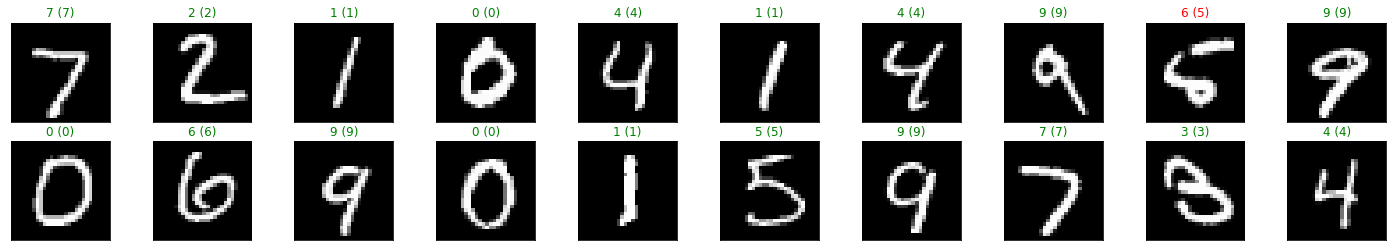

In [4]:
def visualization(w1, b1, w2, b2):
    x = test_x[:20]
    x = x.reshape(x.shape[0], -1)
    y = test_y[:20]
    
    # Forward Pass
    h1 = np.dot(x, w1) + b1
    a1 = sigmoid(h1)
    h2 = np.dot(a1, w2) + b2
    a2 = softmax(h2)
    out = a2    
    pred = np.argmax(out, axis=1)
    
    fig = plt.figure(figsize=(25, 4))
    for index in np.arange(20):
        ax = fig.add_subplot(2, 20/2, index+1, xticks=[], yticks=[])
        ax.imshow(test_x[index], cmap='gray')
        ax.set_title("{} ({})".format(str(pred[index]), str(y[index][0])), 
                     color=("green" if pred[index] == y[index] else "red"))
        
visualization(w1, b1, w2, b2)

# Batch Normalization